In [10]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from random import randint
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [6]:
secrets_file = open("secrets.txt","r")
string = secrets_file.read()
string.split('\n')
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        secrets_dict[line.split(':')[0]]=line.split(':')[1]

In [7]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['cid'],
                                                           client_secret=secrets_dict['csecret']))

Create a pipeline such that when the user enters a song, you:

    1. Check whether or not the song is in the Billboard Hot 200.
    2. Collect the audio features from the Spotify API.

After that, you want to send the Spotify audio features of the submitted song to the clustering model, which should return a cluster number.

In [3]:
hot_songs = pd.read_csv('hot_songs.csv', index_col=0)

In [11]:
#import songs df
songs = pd.read_csv('songs.csv', index_col=0)
#drop title, artist, uri columns from train set
X = songs.drop(['title', 'artist', 'uri'], axis=1)

In [13]:
#scale features
X= StandardScaler().fit_transform(X)

([<matplotlib.axis.XTick at 0x11b0cb160>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

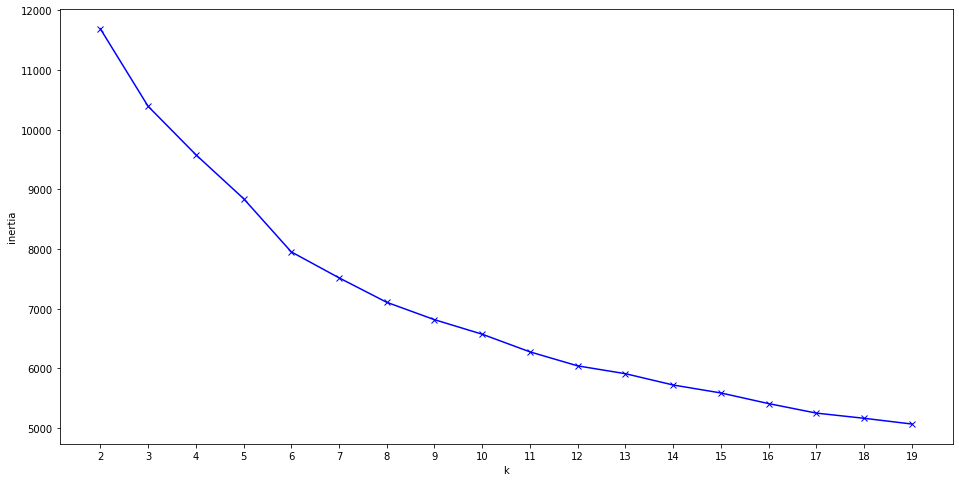

In [14]:
#create cluster model

#try KMeans with optimal k for inertia score
K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=18)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
#k=6 is optimal for inertia score

([<matplotlib.axis.XTick at 0x11b201a90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

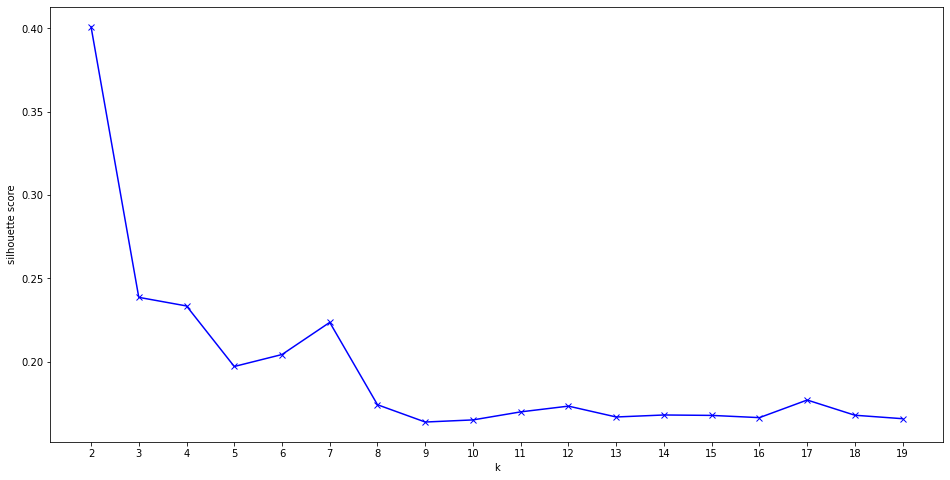

In [15]:
#try KMeans with optimal k for silhouette score
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=18)
    kmeans.fit(X)
    silhouette.append(silhouette_score(X, kmeans.predict(X)))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
#k=7 is optimal for silhouette score

In [17]:
#train KMeans model with optimal k
kmeans = KMeans(n_clusters=7,
                    random_state=18)
kmeans.fit(X)
#add clusters to the song df
pred = kmeans.predict(X)
songs['cluster'] = pred

In [18]:
songs.head()

,title,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,cluster
0,Fever,Dua Lipa,3wJVBz7gvGTwTWVAxFa6ny,0.868,0.693,6,-7.052,0,0.1810,0.0597,0.003990,0.1060,0.396,114.999,4,2
1,Rotate,Becky G,6wwT3PgG3eFuKCpxzjMJFs,0.910,0.856,11,-2.082,0,0.1570,0.0346,0.000223,0.0624,0.771,109.029,4,2
2,Aquí (feat. Ozuna & Soolking),AriBeatz,0259eSt61D349yZvwily88,0.535,0.755,6,-5.354,0,0.0559,0.0420,0.000000,0.1520,0.311,191.931,4,3
3,G-Shit (feat. Blockboi Twitch),Sidhu Moose Wala,5uuVGnkZEFHBz8unViC3iA,0.658,0.761,0,-6.645,1,0.2570,0.0531,0.000000,0.2160,0.843,165.543,4,6
4,M.I.A (feat. Jackson Wang),Afgan,0Uuw4Topqtjut1xQFMXEzU,0.723,0.458,6,-5.572,0,0.1700,0.2560,0.000000,0.0879,0.357,113.954,4,2


In [ ]:
#build song recommender

In [83]:
def song_recommender(song_input):
    
    if song_input in hot_songs.title.values:
        n = random.randint(0,len(hot_songs))
        reco_song_title = hot_songs.title[n]
        reco_song_artist = hot_songs.artist[n]
        return f"We recommend {reco_song_title} by {reco_song_artist}."
    
    else:
        #get uri
        results = sp.search(q= song_input, limit=1, type='track')
        uri = results['tracks']['items'][-1]['uri']

        #get audio features using uri
        song_details = sp.audio_features(uri)
        song_features = song_details[0]
        audio_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
            'liveness', 'valence', 'tempo', 'time_signature']
        song_af = {f:song_features[f] for f in audio_features}
        af = pd.DataFrame(song_af, index=[0])
        
        #find cluster
        pred_cluster = kmeans.predict(af)
        print(pred_cluster)
        
        #suggest song from that cluster
        cluster_songs = songs[songs.cluster == pred_cluster]
        n = random.randint(0,len(cluster_songs))
        reco_song_title = cluster_songs.title[n]
        reco_song_artist = cluster_songs.artist[n]
        return f"We recommend {reco_song_title} by {reco_song_artist}."
    
    

In [84]:
song_recommender('Wait in the Car')

[3]


ValueError: ('Lengths must match to compare', (1559,), (1,))

In [78]:
songs[songs.cluster == 3]

,title,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,cluster
2,Aquí (feat. Ozuna & Soolking),AriBeatz,0259eSt61D349yZvwily88,0.535,0.755,6,-5.354,0,0.0559,0.04200,0.000000,0.1520,0.311,191.931,4,3
38,Hold On !,Qaayel,6CxtpFhcKwdsIgX2MwtaiP,0.394,0.674,7,-6.608,0,0.0708,0.13300,0.000000,0.1330,0.192,140.022,5,3
87,I Dare You (كنتحداك) [feat. Faouzia],Kelly Clarkson,7bK8DBLVCrUPlzyRfiNny2,0.607,0.688,2,-7.194,1,0.0358,0.01200,0.000000,0.1100,0.384,123.979,4,3
96,O Fată Obişnuită,AMI,44zAieIynvghU0rDvfhQnm,0.491,0.628,6,-6.699,1,0.0630,0.31800,0.000000,0.0987,0.456,146.953,4,3
107,Ironic - 2015 Remaster,Alanis Morissette,spotify:track:1d6KS9GH06JAd19uiBy9IE,0.408,0.582,11,-8.305,1,0.0508,0.21800,0.000000,0.1590,0.365,114.926,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,Where The Streets Have No Name - Remastered,U2,4qgZs0RNjdzKAS22lP0QjY,0.490,0.724,2,-9.581,1,0.0366,0.00976,0.004600,0.1590,0.292,125.812,4,3
1545,Never Tear Us Apart,INXS,1GjbTNFImFrjFsNdleDe78,0.664,0.613,0,-7.560,1,0.0273,0.00309,0.000128,0.1750,0.193,96.600,3,3
1550,Heaven,Bryan Adams,7Ewz6bJ97vUqk5HdkvguFQ,0.382,0.589,9,-7.315,0,0.0267,0.04650,0.000000,0.1220,0.335,140.059,4,3
1551,Coming Around Again - Remastered 2004,Carly Simon,10IjsMtp26Om76fzdCZ5me,0.643,0.482,5,-9.130,1,0.0263,0.62400,0.000233,0.0988,0.375,137.445,4,3
